This is a personal notebook to practice machine learning models as a go through my DataCamp lessons.

In [1]:
#load packages
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import cross_val_score
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, ShuffleSplit
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
#import warnings

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv


In [2]:
def concat_df(train_data, test_data):
    # Returns a concatenated df of training and test set on axis 0
    return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)

def divide_df(all_data):
    # Returns divided dfs of training and test set
    return all_data.loc[:890], all_data.loc[891:].drop(['Survived'], axis=1)
# Read the data
df_train = pd.read_csv("/kaggle/input/titanic/train.csv")
df_test = pd.read_csv("/kaggle/input/titanic/test.csv")
df_all = concat_df(df_train, df_test)

df_train.name = 'Training Set'
df_test.name = 'Test Set'
df_all.name = 'All Set' 

dfs = [df_train, df_test]

print('Number of Training Examples = {}'.format(df_train.shape[0]))
print('Number of Test Examples = {}\n'.format(df_test.shape[0]))
print('Training X Shape = {}'.format(df_train.shape))
print('Training y Shape = {}\n'.format(df_train['Survived'].shape[0]))
print('Test X Shape = {}'.format(df_test.shape))
print('Test y Shape = {}\n'.format(df_test.shape[0]))
print(df_train.columns)
print(df_test.columns)

Number of Training Examples = 891
Number of Test Examples = 418

Training X Shape = (891, 12)
Training y Shape = 891

Test X Shape = (418, 11)
Test y Shape = 418

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


**ANALYSING THE DATA**

In [3]:
print(df_all.describe())

               Age         Fare        Parch  PassengerId       Pclass  \
count  1046.000000  1308.000000  1309.000000  1309.000000  1309.000000   
mean     29.881138    33.295479     0.385027   655.000000     2.294882   
std      14.413493    51.758668     0.865560   378.020061     0.837836   
min       0.170000     0.000000     0.000000     1.000000     1.000000   
25%      21.000000     7.895800     0.000000   328.000000     2.000000   
50%      28.000000    14.454200     0.000000   655.000000     3.000000   
75%      39.000000    31.275000     0.000000   982.000000     3.000000   
max      80.000000   512.329200     9.000000  1309.000000     3.000000   

             SibSp    Survived  
count  1309.000000  891.000000  
mean      0.498854    0.383838  
std       1.041658    0.486592  
min       0.000000    0.000000  
25%       0.000000    0.000000  
50%       0.000000    0.000000  
75%       1.000000    1.000000  
max       8.000000    1.000000  


In [4]:
print(df_train.info())
df_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
print(df_test.info())
df_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB
None


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [6]:
def display_missing(df):    
    for col in df.columns.tolist():          
        print('{} column missing values: {}'.format(col, df[col].isnull().sum()))
    print('\n')
    
for df in dfs:
    print('{}'.format(df.name))
    display_missing(df)

Training Set
PassengerId column missing values: 0
Survived column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 177
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 0
Cabin column missing values: 687
Embarked column missing values: 2


Test Set
PassengerId column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 86
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 1
Cabin column missing values: 327
Embarked column missing values: 0




> First we deal with the missing entries of the Age column. The lazy way to do this is to simply replace the missing value by the median of the Age column

In [7]:
df_train.Age = df_train.Age.fillna(df_train.Age.median())
df_test.Age = df_test.Age.fillna(df_test.Age.median())

'Fare'

In [8]:
df_train.Fare = df_train.Fare.fillna(df_train.Fare.mean())
df_test.Fare = df_test.Fare.fillna(df_test.Fare.mean())

'Embarked'

In [9]:
df_train.Embarked = df_train.Embarked.fillna(df_train.Embarked.mode()[0])
df_test.Embarked = df_test.Embarked.fillna(df_test.Embarked.mode()[0])

**Visualization**

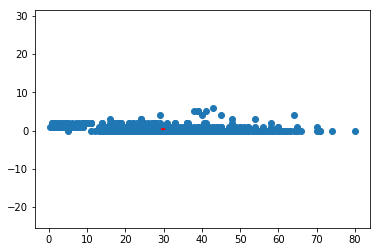

In [10]:
from sklearn.decomposition import PCA
grains = df_train[['Age', 'Parch']].to_numpy()

# Make a scatter plot of the untransformed points
plt.scatter(grains[:,0], grains[:,1])

# Create a PCA instance: model
model = PCA()

# Fit model to points
model.fit(grains)

# Get the mean of the grain samples: mean
mean = model.mean_

# Get the first principal component: first_pc
first_pc = model.components_[0,:]

# Plot first_pc as an arrow, starting at mean
plt.arrow(mean[0], mean[1], first_pc[0], first_pc[1], color='red', width=0.01)

# Keep axes on same scale
plt.axis('equal')
plt.show()

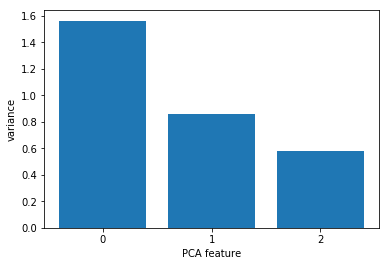

In [11]:
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt

samples = df_train[['Age', 'Parch', 'SibSp']].to_numpy()

# Create scaler: scaler
scaler = StandardScaler()

# Create a PCA instance: pca
pca = PCA()

# Create pipeline: pipeline
pipeline = make_pipeline(scaler,pca)

# Fit the pipeline to 'samples'
pipeline.fit(samples)

# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()


> Let's check if there are any correlations between the features/ columns 

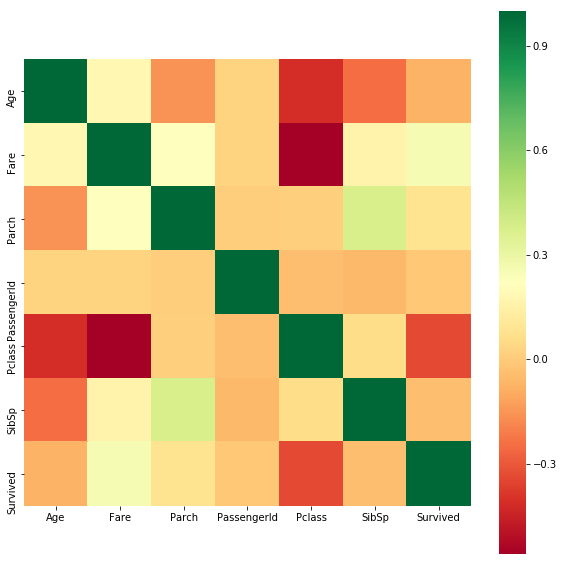

In [12]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df_all.corr(), square=True, cmap='RdYlGn')

> Parch and SibSp are correlated: Also, Fare and Survived. We explore this more later

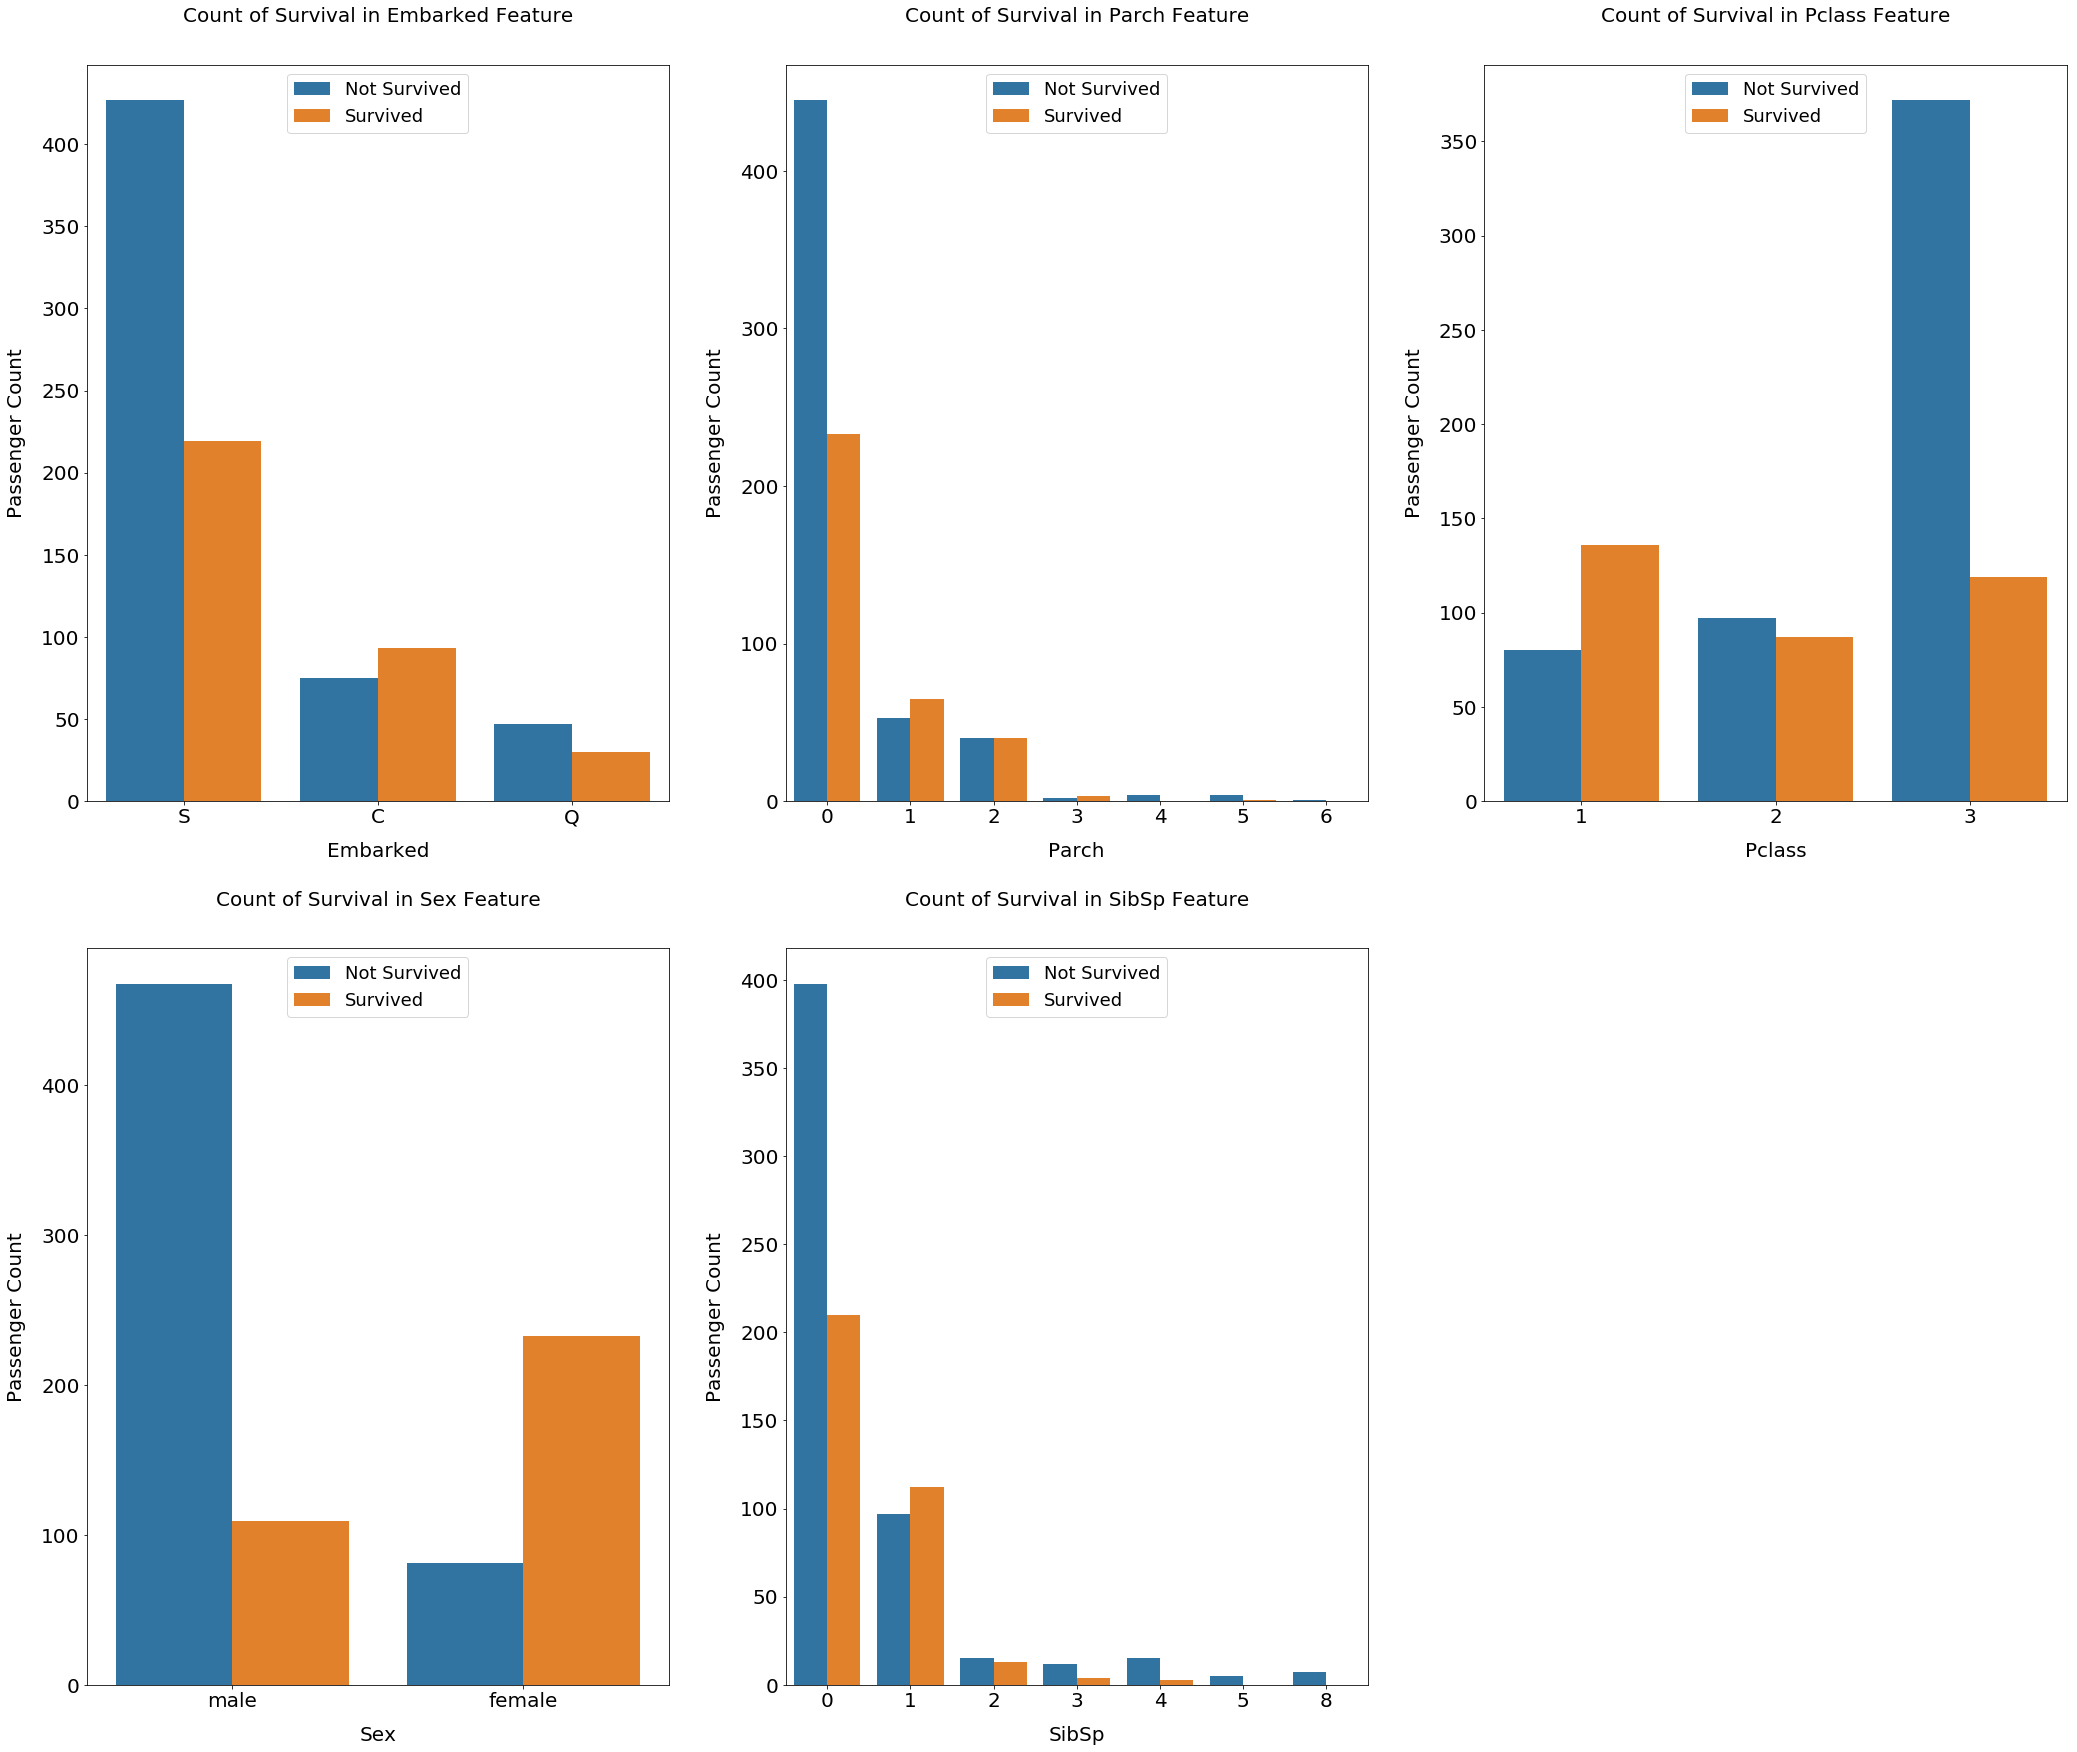

In [13]:
cat_features = ['Embarked', 'Parch', 'Pclass', 'Sex', 'SibSp']

fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(20, 20))
plt.subplots_adjust(right=1.5, top=1.25)

for i, feature in enumerate(cat_features, 1):    
    plt.subplot(2, 3, i)
    sns.countplot(x=feature, hue='Survived', data=df_train)
    
    plt.xlabel('{}'.format(feature), size=20, labelpad=15)
    plt.ylabel('Passenger Count', size=20, labelpad=15)    
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    
    plt.legend(['Not Survived', 'Survived'], loc='upper center', prop={'size': 18})
    plt.title('Count of Survival in {} Feature'.format(feature), size=20, y=1.05)

plt.show()

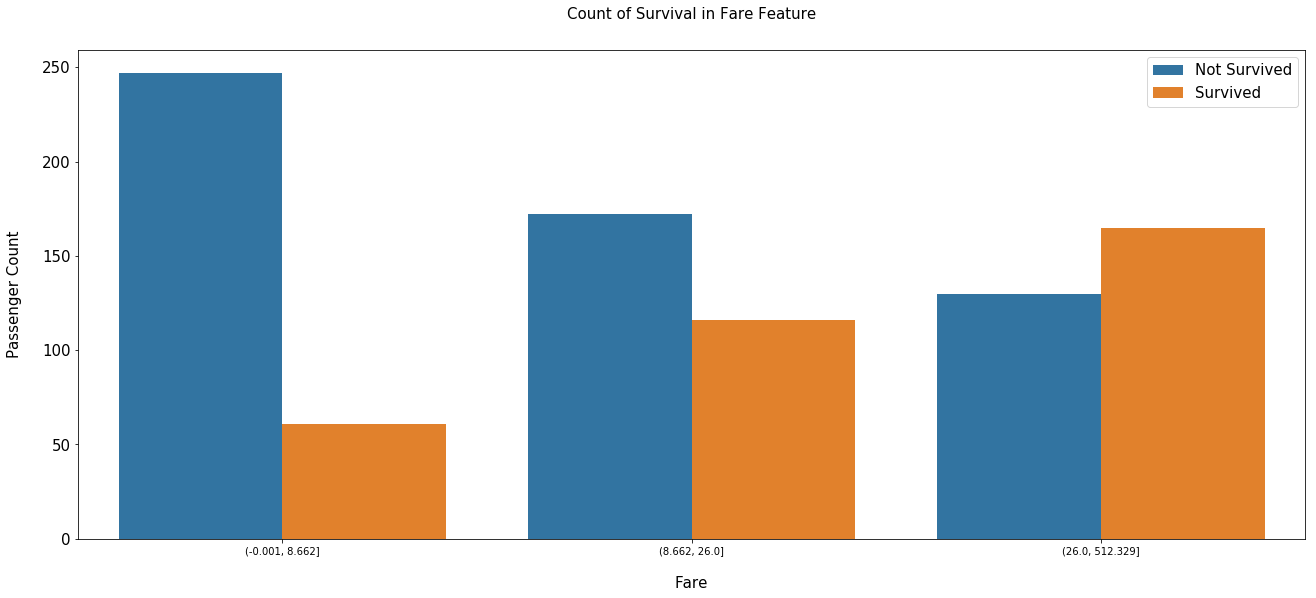

In [14]:
df_all['Fare'] = pd.qcut(df_all['Fare'], 3)

fig, axs = plt.subplots(figsize=(22, 9))
sns.countplot(x='Fare', hue='Survived', data=df_all)

plt.xlabel('Fare', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Count of Survival in {} Feature'.format('Fare'), size=15, y=1.05)

plt.show()


Seems like rich people are highly likely to be saved! :p

In [15]:
df_all['child'] = df_all.Age[df_all.Age <14]
df_all['child'].fillna(0, inplace=True)

In [16]:
def IsChild(x):
    if 0< x <= 14:
        return 1
    return 0

In [17]:
for df in dfs:
    df['child'] = df.Age[df.Age <14]
    df['child'].fillna(0, inplace=True)

In [18]:
df_train.child.apply(IsChild)
df_test.child.apply(IsChild)

0      0
1      0
2      0
3      0
4      0
      ..
413    0
414    0
415    0
416    0
417    0
Name: child, Length: 418, dtype: int64

We must save the young ones!

**Feature Engineering**

Accodring to https://www.anesi.com/titanic.htm women, children from class 1, class 2 and crew have more than 80% survival rate. So let's keep this in mind.

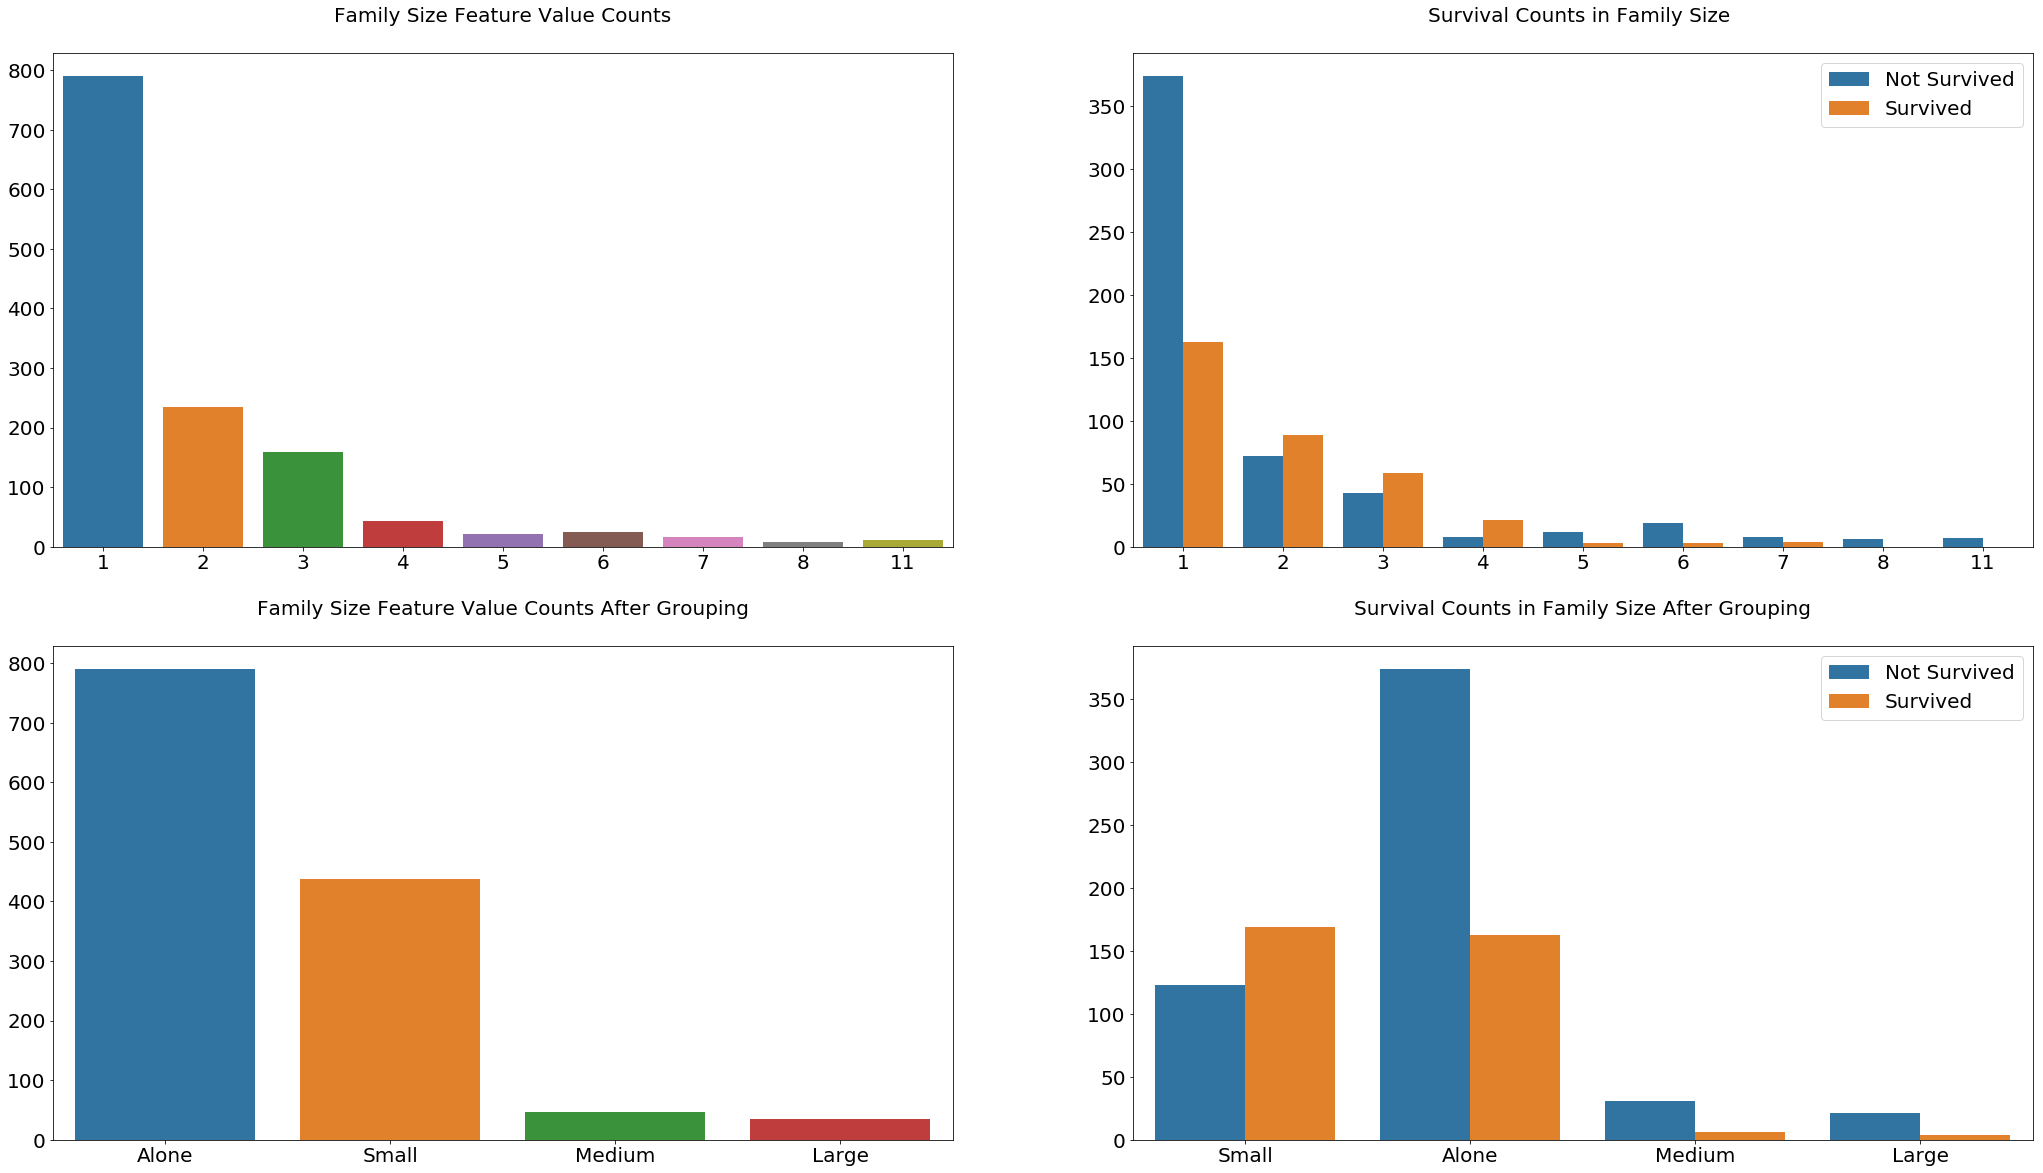

In [19]:
df_train['Family_Size'] = df_train['SibSp'] + df_train['Parch'] + 1
df_test['Family_Size'] = df_test['SibSp'] + df_test['Parch'] + 1
df_all['Family_Size'] = df_all['SibSp'] + df_all['Parch'] + 1

fig, axs = plt.subplots(figsize=(20, 20), ncols=2, nrows=2)
plt.subplots_adjust(right=1.5)

sns.barplot(x=df_all['Family_Size'].value_counts().index, y=df_all['Family_Size'].value_counts().values, ax=axs[0][0])
sns.countplot(x='Family_Size', hue='Survived', data=df_all, ax=axs[0][1])

axs[0][0].set_title('Family Size Feature Value Counts', size=20, y=1.05)
axs[0][1].set_title('Survival Counts in Family Size ', size=20, y=1.05)

family_map = {1: 'Alone', 2: 'Small', 3: 'Small', 4: 'Small', 5: 'Medium', 6: 'Medium', 7: 'Large', 8: 'Large', 11: 'Large'}
df_all['Family_Size_Grouped'] = df_all['Family_Size'].map(family_map)

for df in [df_train, df_test]:
    df['Family_Size_Grouped'] = df['Family_Size'].map(family_map)

sns.barplot(x=df_all['Family_Size_Grouped'].value_counts().index, y=df_all['Family_Size_Grouped'].value_counts().values, ax=axs[1][0])
sns.countplot(x='Family_Size_Grouped', hue='Survived', data=df_all, ax=axs[1][1])

axs[1][0].set_title('Family Size Feature Value Counts After Grouping', size=20, y=1.05)
axs[1][1].set_title('Survival Counts in Family Size After Grouping', size=20, y=1.05)

for i in range(2):
    axs[i][1].legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 20})
    for j in range(2):
        axs[i][j].tick_params(axis='x', labelsize=20)
        axs[i][j].tick_params(axis='y', labelsize=20)
        axs[i][j].set_xlabel('')
        axs[i][j].set_ylabel('')

plt.show()

**MACHINE LEARNING MODELS**

In [20]:
# Obtain target and predictors
y = df_train['Survived']
features = ['Pclass', 'Sex', 'child', 'Family_Size_Grouped'] 

X = pd.get_dummies(df_train[features])
X_test_full = pd.get_dummies(df_test[features])
X_full = pd.get_dummies(df_all[features])

Try a naive out-of-the-box model **K- Nearest Neighbor** to start

In [21]:
# Import necessary modules
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=505, stratify= y)

# Create a k-NN classifier with 6 neighbors: knn
knn = KNeighborsClassifier(n_neighbors = 6)

# Fit the classifier to the training data
knn.fit(X_train,y_train)

# Print the accuracy
print(knn.score(X_test, y_test))

0.7877094972067039


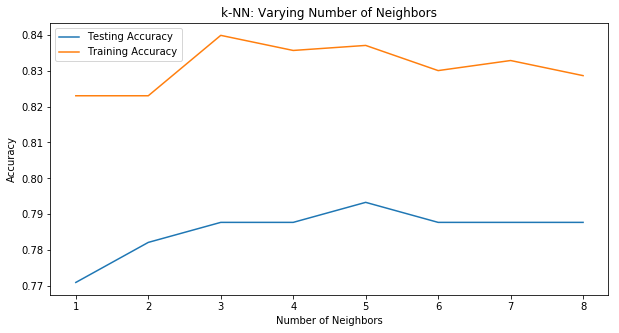

In [22]:
# Setup arrays to store train and test accuracies
neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit the classifier to the training data
    knn.fit(X_train,y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, y_test)

# Generate plot
fig, axs = plt.subplots(figsize=(10, 5))
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

Due to **class imbalance**, i.e. there was ~30% surviving rate, we will look at the confusion matrix and classification report since this is good practice.

In [23]:
# Import necessary modules
from sklearn.metrics import classification_report, confusion_matrix

# Predict the labels of the test data: y_pred
y_pred = knn.predict(X_test)

# Generate the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[99 11]
 [27 42]]
              precision    recall  f1-score   support

           0       0.79      0.90      0.84       110
           1       0.79      0.61      0.69        69

    accuracy                           0.79       179
   macro avg       0.79      0.75      0.76       179
weighted avg       0.79      0.79      0.78       179



Below demonstrates the power of rescaling your data.

In [24]:
# Import the necessary modules
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

# Setup the pipeline steps: steps
steps = [('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier())]
        
# Create the pipeline: pipeline
pipeline = Pipeline(steps)

# Specify the hyperparameter space
neighbors = np.arange(1, 9)
parameters = {'knn__n_neighbors':neighbors}

# Instantiate the GridSearchCV object: cv
knn_cv = GridSearchCV(pipeline, param_grid= parameters, scoring='accuracy', cv=5)

# Fit to the training set
knn_cv.fit(X_train, y_train)

# Predict the labels of the test set: y_pred
y_pred = knn_cv.predict(X_test)

# Instantiate and fit a k-NN classifier to the unscaled data
knn_unscaled = GridSearchCV(KNeighborsClassifier(), param_grid= {'n_neighbors': neighbors}, scoring='accuracy', cv=5).fit(X_train, y_train)

# Compute and print metrics
print("Accuracy: {}".format(knn_cv.score(X_test, y_test)))
print('Accuracy without Scaling: {}'.format(knn_unscaled.score(X_test, y_test)))
print(classification_report(y_test, y_pred))
print("Tuned Model Parameters: {}".format(knn_cv.best_params_))

Accuracy: 0.7932960893854749
Accuracy without Scaling: 0.7877094972067039
              precision    recall  f1-score   support

           0       0.79      0.90      0.84       110
           1       0.80      0.62      0.70        69

    accuracy                           0.79       179
   macro avg       0.79      0.76      0.77       179
weighted avg       0.79      0.79      0.79       179

Tuned Model Parameters: {'knn__n_neighbors': 5}


**SUPPORT VECTOR MACHINES**  
*C-Support Vector Classification*

In [25]:
# Setup the pipeline
steps = [('scaler', StandardScaler()),
         ('SVM', SVC(random_state=505))]

pipeline = Pipeline(steps)

# Specify the hyperparameter space
parameters = {'SVM__C':[1, 10, 100],
              'SVM__gamma':[0.1, 0.01]}

# Instantiate the GridSearchCV object: cv
cv = GridSearchCV(pipeline, param_grid= parameters, scoring='accuracy', cv=5)

# Fit to the training set
cv.fit(X_train, y_train)

# Predict the labels of the test set: y_pred
y_pred = cv.predict(X_test)

# Instantiate and fit a SVC classifier to the unscaled data
svc_unscaled = GridSearchCV(SVC(random_state=505), param_grid= {'C':[1, 10, 100], 'gamma':[0.1, 0.01]}, scoring='accuracy', cv=5).fit(X_train, y_train)

# Compute and print metrics
print("Accuracy: {}".format(cv.score(X_test, y_test)))
print('Accuracy without Scaling: {}'.format(svc_unscaled.score(X_test, y_test)))
print(classification_report(y_test, y_pred))
print("Tuned Model Parameters: {}".format(cv.best_params_))

Accuracy: 0.7988826815642458
Accuracy without Scaling: 0.8044692737430168
              precision    recall  f1-score   support

           0       0.82      0.85      0.84       110
           1       0.75      0.71      0.73        69

    accuracy                           0.80       179
   macro avg       0.79      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179

Tuned Model Parameters: {'SVM__C': 10, 'SVM__gamma': 0.1}


> The models below do not get affected by rescaling 

**Logistic Regression**

In [26]:
# Import the necessary modules
from sklearn.linear_model import LogisticRegression

# Create the classifier: logreg
logreg = LogisticRegression()

# Fit the classifier to the training data
logreg.fit(X_train,y_train)

# Predict the labels of the test set: y_pred
y_pred_log = logreg.predict(X_test)

# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))

[[94 16]
 [20 49]]
              precision    recall  f1-score   support

           0       0.82      0.85      0.84       110
           1       0.75      0.71      0.73        69

    accuracy                           0.80       179
   macro avg       0.79      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179



/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


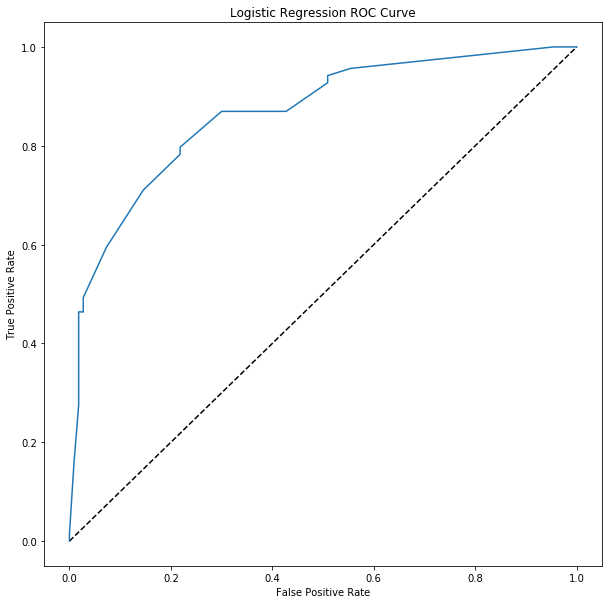

In [27]:
# Import necessary modules
from sklearn.metrics import roc_curve

# Compute predicted probabilities: y_pred_prob
y_pred_prob = logreg.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
fig, axs = plt.subplots(figsize=(10, 10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show()

In [28]:
# Compute and print AUC score
print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))

# Compute cross-validated AUC scores: cv_auc
cv_auc = cross_val_score(logreg, X, y, cv=5, scoring='roc_auc', n_jobs=4)

# Print list of AUC scores
print("AUC scores computed using 5-fold cross-validation: {}".format(cv_auc))
print("Average 5-Fold CV AUC Scores: {}".format(np.mean(cv_auc)))

AUC: 0.8656785243741765
AUC scores computed using 5-fold cross-validation: [0.84802372 0.82444005 0.86076203 0.86283422 0.86400432]
Average 5-Fold CV AUC Scores: 0.8520128684247388


In [29]:
# Import necessary modules
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Setup the pipeline
steps = [('scaler', StandardScaler()),
         ('logreg', LogisticRegression(solver='liblinear',random_state=505))]

pipeline = Pipeline(steps)

# Setup the hyperparameter grid
c_space = np.logspace(-5, 8, 15)
param_grid = {'logreg__C': c_space}

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(pipeline, param_grid, scoring = 'accuracy', cv=5, n_jobs=4)

# Fit it to the training data 
logreg_cv.fit(X_train,y_train)

# Predict the labels of the test set: y_pred
y_pred = logreg_cv.predict(X_test)

# Instantiate and fit a SVC classifier to the unscaled data
logreg_unscaled = GridSearchCV(LogisticRegression(solver='liblinear', random_state=505),
                               param_grid= {'C':c_space},
                               scoring='accuracy',
                               cv=5).fit(X_train, y_train)

# Compute and print metrics
print("Accuracy: {}".format(logreg_cv.score(X_test, y_test)))
print('Accuracy without Scaling: {}'.format(logreg_unscaled.score(X_test, y_test)))
print(classification_report(y_test, y_pred))
print("Tuned Model Parameters: {}".format(logreg_cv.best_params_))

Accuracy: 0.7988826815642458
Accuracy without Scaling: 0.7988826815642458
              precision    recall  f1-score   support

           0       0.82      0.85      0.84       110
           1       0.75      0.71      0.73        69

    accuracy                           0.80       179
   macro avg       0.79      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179

Tuned Model Parameters: {'logreg__C': 0.4393970560760795}


**Random Forest Classifier**

In [30]:
# Setup the hyperparameter grid
param_grid= {'n_estimators':[10,100],
             'max_depth':[3,6],
             'criterion':['gini','entropy']}

# Instantiate the GridSearchCV object: RandomForestClassifier
rf_cv = GridSearchCV(RandomForestClassifier(random_state=105),
                     param_grid,
                     scoring='accuracy',
                     cv=5)

# Fit it to the training data 
rf_cv.fit(X_train,y_train)

# Predict the labels of the test set: y_pred
y_pred = rf_cv.predict(X_test)

# Compute and print metrics
print("Accuracy: {}".format(rf_cv.score(X_test, y_test)))
print(classification_report(y_test, y_pred))
print("Tuned Model Parameters: {}".format(rf_cv.best_params_))

Accuracy: 0.8100558659217877
              precision    recall  f1-score   support

           0       0.84      0.85      0.85       110
           1       0.76      0.74      0.75        69

    accuracy                           0.81       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179

Tuned Model Parameters: {'criterion': 'gini', 'max_depth': 6, 'n_estimators': 100}


**Extreme Gradient Boosting with GridSearchCV**

In [31]:
# Setup the hyperparameter grid
param_grid = {
    "n_estimators":[50,100],
    "learning_rate":[0.1,0.01],
    'max_depth': [3,6],
 }

# Instantiate the GridSearchCV object with objective= 'binary:logistic'
xgb_cv = GridSearchCV(XGBClassifier(objective= 'binary:logistic', random_state=505), 
                      param_grid, scoring = 'accuracy', cv=5, n_jobs=4)

# Fit it to the training data 
xgb_cv.fit(X_train,y_train)

# Predict the labels of the test set: y_pred
y_pred = xgb_cv.predict(X_test)

# Instantiate and fit a XGB classifier with objective= 'binary:hinge'
xgb_hinge = GridSearchCV(XGBClassifier(objective= 'binary:hinge', random_state=505), param_grid, 
                            scoring='accuracy', cv=5).fit(X_train, y_train)

# Compute and print metrics
print("Accuracy with binary logistic: {}".format(xgb_cv.score(X_test, y_test)))
print('Accuracy with binary hinge: {}'.format(xgb_hinge.score(X_test, y_test)))
print(classification_report(y_test, y_pred))
print("Tuned Model Parameters: {}".format(xgb_cv.best_params_))

Accuracy with binary logistic: 0.8100558659217877
Accuracy with binary hinge: 0.8100558659217877
              precision    recall  f1-score   support

           0       0.84      0.85      0.85       110
           1       0.76      0.74      0.75        69

    accuracy                           0.81       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179

Tuned Model Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}


[0.17114219 0.04345002 0.6011066  0.         0.01712211 0.03890107
 0.06474977 0.0635283 ]


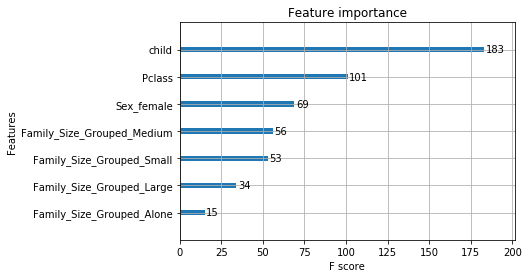

In [32]:
from xgboost import plot_importance
# fit model no training data
model = XGBClassifier()
model.fit(X, y)
# feature importance
print(model.feature_importances_)
# plot
plot_importance(model)
#plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.show()

**Extreme Gradient Boosting with RandomizedSearchCV**

In [33]:
# Import necessary modules
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

# Setup the parameters and distributions to sample from: param_dist
param_dist = {
    "n_estimators":randint(10, 100),
    "learning_rate":[0.5, 0.1, 0.01, 0.001],
    'max_depth': randint(1, 9),
 }

# Instantiate the RandomizedSearchCV object: tree_cv
xgb_rs = RandomizedSearchCV(XGBClassifier(objective= 'binary:logistic', random_state=23),
                            param_dist,
                            cv=10,
                            n_jobs=4,
                           random_state=2,
                           n_iter=20)

# Fit it to the data
xgb_rs.fit(X_train,y_train)

# Predict the labels of the test set: y_pred
y_pred = xgb_rs.predict(X_test)

# Compute and print metrics
print("Accuracy: {}".format(xgb_rs.score(X_test, y_test)))
print(classification_report(y_test, y_pred))
print("Tuned Model Parameters: {}".format(xgb_rs.best_params_))

Accuracy: 0.7988826815642458
              precision    recall  f1-score   support

           0       0.80      0.90      0.85       110
           1       0.80      0.64      0.71        69

    accuracy                           0.80       179
   macro avg       0.80      0.77      0.78       179
weighted avg       0.80      0.80      0.79       179

Tuned Model Parameters: {'learning_rate': 0.001, 'max_depth': 7, 'n_estimators': 43}


**KERAS**

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.


Train on 712 samples, validate on 179 samples
Epoch 1/50
712/712 [==============================] - 0s 546us/step - loss: 0.6068 - accuracy: 0.6756 - val_loss: 0.5165 - val_accuracy: 0.8045
Epoch 2/50
712/712 [==============================] - 0s 69us/step - loss: 0.5319 - accuracy: 0.7584 - val_loss: 0.4761 - val_accuracy: 0.8101
Epoch 3/50
712/712 [==============================] - 0s 67us/step - loss: 0.5009 - accuracy: 0.7949 - val_loss: 0.4486 - val_accuracy: 0.8212
Epoch 4/50
712/712 [==============================] - 0s 70us/step - loss: 0.4802 - accuracy: 0.8034 - val_loss: 0.4309 - val_accuracy: 0.8212
Epoch 5/50
712/712 [==============================] - 0s 70us/step - loss: 0.4589 - accuracy: 0.8132 - val_loss: 0.4192 - val_accuracy: 0.8156
Epoch 6/50
712/712 [==============================] - 0s 70us/step - loss: 0.4441 - accuracy: 0.8132 - val_loss: 0.3977 - val_accuracy: 0.8380
Epoch 7/50
712/712 [==============================] - 0s 70us/step - loss: 0.4373 - accuracy: 0

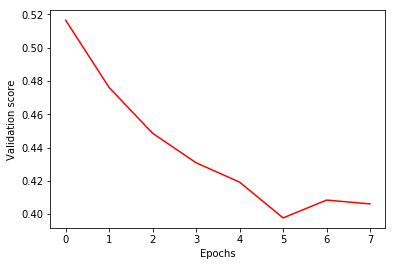

In [34]:
# Import necessary modules
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

n_cols = X.shape[1]

predictors = X.as_matrix()
# Convert the target to categorical: target
target = to_categorical(y)

# Set up the model
model = Sequential()

# Add the desired number of layers
model.add(Dense(100, activation='relu', input_shape=(n_cols,)))

model.add(Dense(50, activation='relu'))

model.add(Dense(20, activation='relu'))

model.add(Dense(10, activation='relu'))
# Add the output layer
model.add(Dense(2,activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping_monitor = EarlyStopping(patience=2)
# Fit the model
model_1 = model.fit(predictors, target, epochs=50, validation_split=0.2, callbacks=[early_stopping_monitor])

# Create the plot
plt.plot(model_1.history['val_loss'], 'r')
plt.xlabel('Epochs')
plt.ylabel('Validation score')
plt.show()

**FINAL MODEL**

In [35]:
# Tuned Model Parameters: {'criterion': 'gini', 'max_depth': 3, 'max_features': 8, 'min_samples_leaf': 6}
predictors_test = X_test_full.as_matrix()

# Generate test predictions
pred_test = model.predict(predictors_test)
pd.Series(pred_test[:,1]).round().astype(int)

output = pd.DataFrame({'PassengerId': df_test.PassengerId, 'Survived': pd.Series(pred_test[:,1]).round().astype(int)})
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Your submission was successfully saved!
